<a href="https://colab.research.google.com/github/jiyeon712/Violin_Guitar/blob/main/violin_guitar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls /content/drive/MyDrive/2023bigdb/실습/data

guitar/  TR/  TS/  violin/  VL/


In [ ]:
import time

import timeit

start_time = time.time()

In [ ]:
from tensorflow import keras
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.applications import VGG16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import image_dataset_from_directory     # DL 전처리 함수
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 이미지 증강 함수

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 공통 조기종료콜백 지정.
# model.fit(callbacks=)로 지정. 20 epoch 동안 개선 없으면 조기종료

ES = EarlyStopping(monitor='val_loss', patience=20)

### 데이터 나누기

In [ ]:
TRDF = image_dataset_from_directory(
    '/content/drive/MyDrive/2023bigdb/실습/data/TR',
    image_size=(180, 180),  # 입력이미지를 (180,180)으로 통일
    seed=1234,              # seed 지정
    batch_size=32)          # 기본값: batch_size=32, shuffle=True

VLDF = image_dataset_from_directory(
    '/content/drive/MyDrive/2023bigdb/실습/data/VL',
    image_size=(180, 180),
    seed=1234,              # seed 지정
    batch_size=32)          # shuffle=True 파일순서 랜덤화해야 함

TSDF = image_dataset_from_directory(
    '/content/drive/MyDrive/2023bigdb/실습/data/TS',
    image_size=(180, 180),
    batch_size=1,
    shuffle=False)   # shuffle=False 파일순서 섞지 말 것(확인시 불편)

Found 625 files belonging to 2 classes.
Found 155 files belonging to 2 classes.
Found 155 files belonging to 2 classes.


### 모델 생성

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inp = keras.Input(shape=(180, 180, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inp)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)

x = layers.Flatten()(x)

outp = layers.Dense(1, activation='sigmoid')(x)
Mcnn = keras.Model(inputs=inp, outputs=outp)
Mcnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856 

In [ ]:
# 모형 컴파일: 손실함수, 최적화 알고리듬, 평가측도 지정

Mcnn.compile(loss='binary_crossentropy',  # 이진분류
             optimizer='rmsprop',
             metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
MCcnn = ModelCheckpoint('/content/drive/MyDrive/2023bigdb/실습/best_model/Mcnn0.tf',
                        monitor='val_loss',
                        save_best_only=True) #  save_format='tf')

Hcnn = Mcnn.fit(TRDF, epochs=30,
                callbacks=[MCcnn, ES],
                validation_data=VLDF)

Epoch 1/30
20/20 [==============================] - 117s 3s/step - loss: 266.6483 - accuracy: 0.4912 - val_loss: 0.8243 - val_accuracy: 0.5226
Epoch 2/30
20/20 [==============================] - 2s 61ms/step - loss: 0.5907 - accuracy: 0.6864 - val_loss: 0.8509 - val_accuracy: 0.5548
Epoch 3/30
20/20 [==============================] - 2s 82ms/step - loss: 5.4475 - accuracy: 0.7040 - val_loss: 0.9260 - val_accuracy: 0.5161
Epoch 4/30
20/20 [==============================] - 2s 92ms/step - loss: 0.7049 - accuracy: 0.7728 - val_loss: 0.9469 - val_accuracy: 0.5548
Epoch 5/30
20/20 [==============================] - 2s 73ms/step - loss: 0.6953 - accuracy: 0.8144 - val_loss: 7.1806 - val_accuracy: 0.5161
Epoch 6/30
20/20 [==============================] - 2s 63ms/step - loss: 0.7135 - accuracy: 0.8208 - val_loss: 15.5072 - val_accuracy: 0.5032
Epoch 7/30
20/20 [==============================] - 2s 63ms/step - loss: 3.5248 - accuracy: 0.7984 - val_loss: 1.6615 - val_accuracy: 0.5097
Epoch 8/30

In [ ]:
def plot_history(history):
 hist = pd.DataFrame(history.history)
 hist['epoch'] = history.epoch
 if 'acc' in hist.columns:
    hist = hist.rename(columns = {'acc':'accuracy'})
 if 'val_acc' in hist.columns:
    hist = hist.rename(columns = {'val_acc':'val_accuracy'})

 plt.figure(figsize=(10, 5))
 plt.subplot(2,1,1);plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.grid();
 plt.plot(hist['epoch'],hist['accuracy'], marker='.',label='TR')
 plt.plot(hist['epoch'],hist['val_accuracy'], marker='.',label='VL')
 plt.legend() #plt.ylim([0,5])
 plt.subplot(2,1,2);plt.xlabel('Epoch');plt.ylabel('Loss');plt.grid();
 plt.plot(hist['epoch'],hist['loss'], marker='.',label='TR')
 plt.plot(hist['epoch'],hist['val_loss'], marker='.',label='VL')
 plt.legend() #plt.ylim([0,20])
 plt.show()

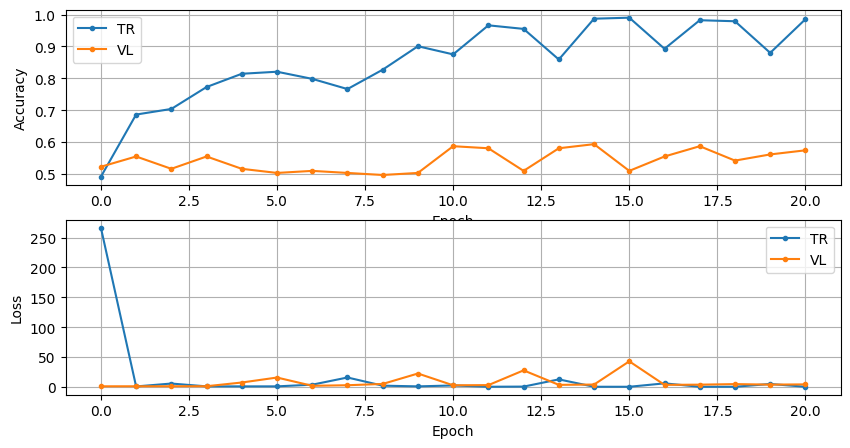

In [ ]:
plot_history(Hcnn)

In [ ]:
# 모델 저장

Mcnn0 = keras.models.load_model('/content/drive/MyDrive/2023bigdb/실습/best_model/Mcnn0.tf')

test_loss, test_acc = Mcnn0.evaluate(TSDF)

print(f'Test accuracy: {test_acc:.3f}')  # 56%

155/155 [==============================] - 28s 174ms/step - loss: 0.7182 - accuracy: 0.4839
Test accuracy: 0.484


In [ ]:
import os
vio = [os.path.abspath(os.path.join('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin', fn)) for fn in os.listdir('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin')]
gib = [os.path.abspath(os.path.join('/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar', fn)) for fn in os.listdir('/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar')]

imgnames = vio+gib

imgnames[:3]+ imgnames[100:103]

['/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_003.jpg',
 '/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_001.jpg',
 '/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_015.jpg',
 '/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_006.jpg',
 '/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_023.jpg',
 '/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_022.jpg']

In [ ]:
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_003.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_021.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_038.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_060.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_020.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_006.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_041.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_063.jpg
['guitar', 'violin']


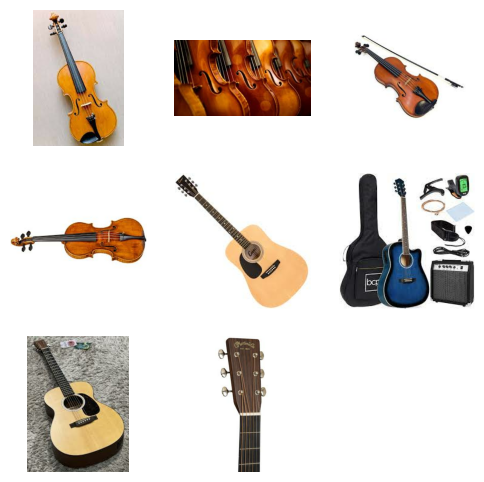

In [ ]:
examples = imgnames[0:200:20]
plt.figure(figsize=(6, 6))

for i, img in enumerate(examples[:9]):
    print(img)
    ax = plt.subplot(3, 3, i + 1)
    im = io.read_file(img)                 # tf.io.read_file
    im = image.decode_png(im, channels=3)  # image.decode_png. output channel=3(RGB), 1(gray), 3(RGBA), 0(내장)
    plt.imshow(im)
    # plt.title(f'{img}')
    plt.axis('off')

print(TSDF.class_names)

In [ ]:
TSy = np.concatenate([y for x, y in TSDF], axis=0)
# TSy = TSy.reshape(-1)
TSy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

In [ ]:
import os
TSph = np.array([])

In [ ]:
for imgname in imgnames:
    img = keras.utils.load_img(imgname, target_size=(180, 180))
    img_tensor = keras.utils.img_to_array(img)  # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    #img_tensor /= 255.
    ph = Mcnn0.predict(img_tensor, verbose=0).item() # (1,1) 을 (1,)로 변형
    TSph = np.append(TSph, ph) # TSph는 P(y=1|x)

TSyh = np.where(TSph>=0.5, 1, 0)
np.c_[TSy, TSph, TSyh][:5,]

array([[0.        , 0.42183629, 0.        ],
       [0.        , 0.73800206, 1.        ],
       [0.        , 0.49290857, 0.        ],
       [0.        , 0.10398497, 0.        ],
       [0.        , 0.70831507, 1.        ]])

In [ ]:
# 오분류표 작성
# tf의 confusion_matrix, sk의 confusion_matrix 충돌
# tf로 구하고, sk로 그리기

import tensorflow as tf
tf.math.confusion_matrix(labels=TSy, predictions=TSyh)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[34, 42],
       [36, 43]], dtype=int32)>

0.4967741935483871


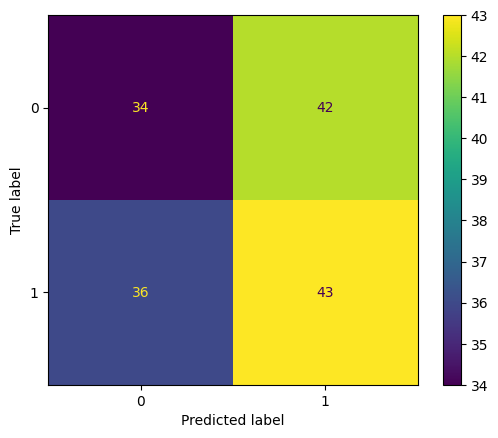

In [ ]:
# sk의 confusion_matrix
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

# print(classification_report(TSy, TSyh)) # Confusing
print(accuracy_score(TSy, TSyh))

# tf의 오분류표를 그대로 sk의 ConfusionMatrixDisplay에 입력하면 됨
disp = ConfusionMatrixDisplay(tf.math.confusion_matrix(labels=TSy, predictions=TSyh).numpy())
disp.plot()

In [ ]:
# 예측값 저장
TSOUT = pd.DataFrame({'y':TSy, 'phcnn':TSph, 'yhcnn':TSyh})
TSOUT.head()

,y,phcnn,yhcnn
0,0,0.421836,0
1,0,0.738002,1
2,0,0.492909,0
3,0,0.103985,0
4,0,0.708315,1


In [ ]:
MET = pd.DataFrame(
    {'tr_loss':Hcnn.history['loss'][-1],
     'tr_acc':Hcnn.history['accuracy'][-1],
     'val_loss':Hcnn.history['val_loss'][-1],
     'val_acc':Hcnn.history['val_accuracy'][-1],
     'test_loss':test_loss,
     'test_acc':test_acc}, index=['cnn'] )

# test_loss, test_acc는 Mcnn0.evaluate(TSDF)로 저장한 값임
MET

,tr_loss,tr_acc,val_loss,val_acc,test_loss,test_acc
cnn,0.046731,0.9856,4.036592,0.574194,0.718233,0.483871


In [ ]:
AUG = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)])

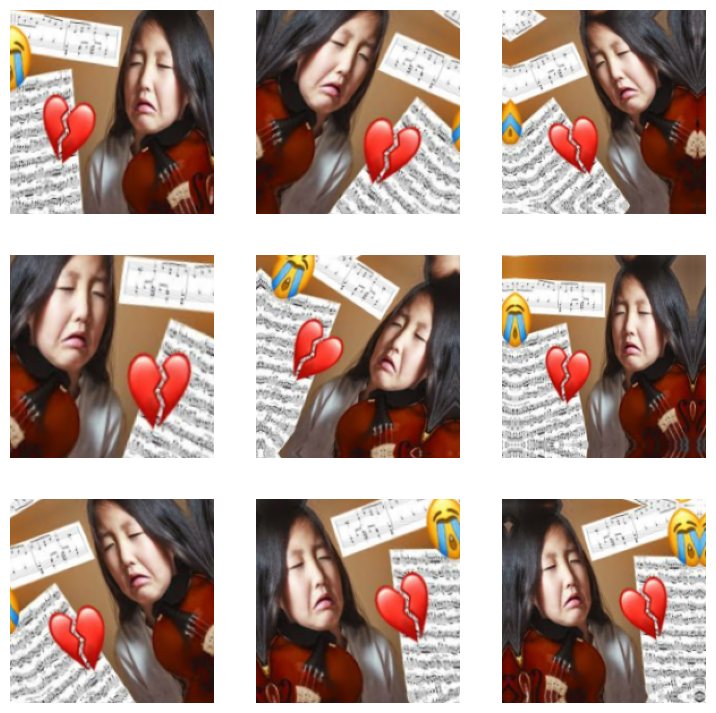

In [ ]:
plt.figure(figsize=(9, 9))
for img, _ in TRDF.take(1):
    for i in range(9):
        aug_img = AUG(img)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')

In [ ]:
inp = keras.Input(shape=(180, 180, 3))
x = AUG(inp)                                # 증강층
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)
outp = layers.Dense(1, activation='sigmoid')(x)
Maug = keras.Model(inputs=inp, outputs=outp)

In [ ]:
Maug.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [ ]:
MCaug = ModelCheckpoint('/content/drive/MyDrive/2023bigdb/실습/best_model/Maug0.tf',

                        monitor='val_loss', save_best_only=True)

Haug = Maug.fit(TRDF, epochs=30,

                callbacks=[MCaug, ES],

                validation_data=VLDF)

Epoch 1/30
20/20 [==============================] - 10s 283ms/step - loss: 0.6966 - accuracy: 0.4848 - val_loss: 0.6916 - val_accuracy: 0.5097
Epoch 2/30
20/20 [==============================] - 6s 255ms/step - loss: 0.6950 - accuracy: 0.5248 - val_loss: 0.6899 - val_accuracy: 0.6839
Epoch 3/30
20/20 [==============================] - 5s 234ms/step - loss: 0.6944 - accuracy: 0.5072 - val_loss: 0.6896 - val_accuracy: 0.5806
Epoch 4/30
20/20 [==============================] - 4s 159ms/step - loss: 0.6919 - accuracy: 0.5744 - val_loss: 0.6525 - val_accuracy: 0.6129
Epoch 5/30
20/20 [==============================] - 4s 173ms/step - loss: 0.6863 - accuracy: 0.6048 - val_loss: 0.6464 - val_accuracy: 0.6323
Epoch 6/30
20/20 [==============================] - 2s 65ms/step - loss: 0.6459 - accuracy: 0.6080 - val_loss: 0.8661 - val_accuracy: 0.5484
Epoch 7/30
20/20 [==============================] - 4s 189ms/step - loss: 0.6639 - accuracy: 0.6080 - val_loss: 0.6061 - val_accuracy: 0.6839
Epoch 

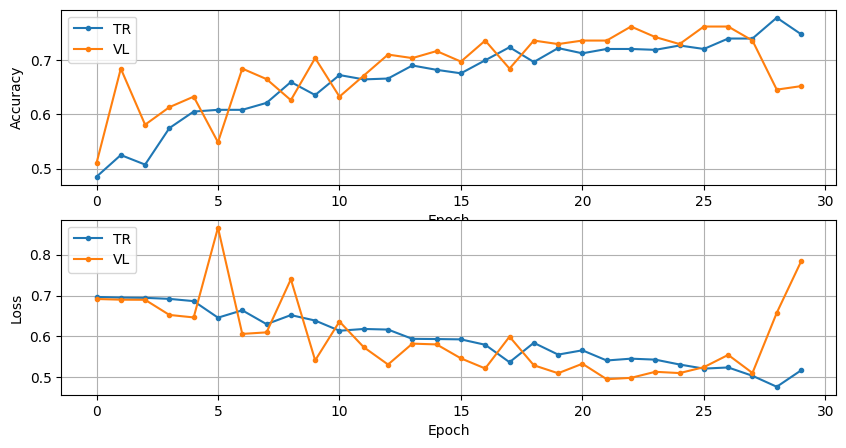

In [ ]:
plot_history(Haug)

In [ ]:
Maug0 = keras.models.load_model('/content/drive/MyDrive/2023bigdb/실습/best_model/Maug0.tf')

test_loss, test_acc = Maug0.evaluate(TSDF)

print(f'Test accuracy: {test_acc:.3f}')  # 61%

155/155 [==============================] - 1s 4ms/step - loss: 0.4090 - accuracy: 0.8065
Test accuracy: 0.806


In [ ]:
TSph = np.array([])

for imgname in imgnames:
    img = keras.utils.load_img(imgname, target_size=(180, 180))
    img_tensor = keras.utils.img_to_array(img)  # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    #img_tensor /= 255.
    ph = Maug0.predict(img_tensor, verbose=0).item() # (1,1) 을 (1,)로 변형
    TSph = np.append(TSph, ph)

In [ ]:
TSyh = np.where(TSph>=0.5, 1, 0)
np.c_[TSy, TSph, TSyh][:5,]

array([[0.        , 0.32327172, 0.        ],
       [0.        , 0.80977833, 1.        ],
       [0.        , 0.94828242, 1.        ],
       [0.        , 0.63859272, 1.        ],
       [0.        , 0.92816031, 1.        ]])

0.1935483870967742


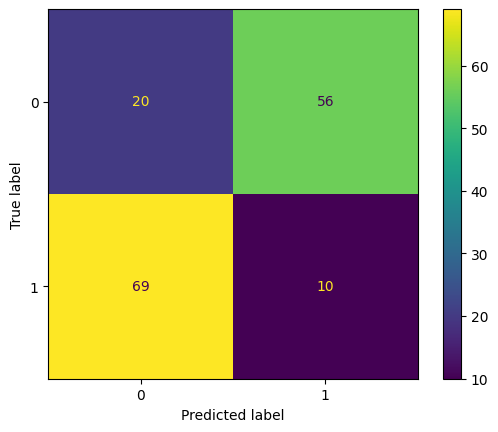

In [ ]:
# tf의 confusion_matrix, sk의 confusion_matrix 충돌
# tf로 구하고, sk로 그리기
# import tensorflow as tf

tf.math.confusion_matrix(labels=TSy, predictions=TSyh) # tensor. numpy()화해야 sk 사용가능
# from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report# confusion_matrix

# print(classification_report(TSy, TSyh)) # Confusing

print(accuracy_score(TSy, TSyh)) # 59.5%  evaluate결과와 다름
disp = ConfusionMatrixDisplay(tf.math.confusion_matrix(labels=TSy, predictions=TSyh).numpy())
disp.plot()

In [ ]:
TSOUT['phaug'] = TSph
TSOUT['yhaug'] = TSyh
TSOUT.head()

,y,phcnn,yhcnn,phaug,yhaug
0,0,0.421836,0,0.323272,0
1,0,0.738002,1,0.809778,1
2,0,0.492909,0,0.948282,1
3,0,0.103985,0,0.638593,1
4,0,0.708315,1,0.928160,1


In [ ]:
met = pd.DataFrame(
    {'tr_loss':Haug.history['loss'][-1],
     'tr_acc':Haug.history['accuracy'][-1],
     'val_loss':Haug.history['val_loss'][-1],
     'val_acc':Haug.history['val_accuracy'][-1],
     'test_loss':test_loss,
     'test_acc':test_acc}, index=['aug'] )

MET = pd.concat([MET, met])
MET

,tr_loss,tr_acc,val_loss,val_acc,test_loss,test_acc
cnn,0.046731,0.9856,4.036592,0.574194,0.718233,0.483871
aug,0.516871,0.7472,0.783353,0.651613,0.408982,0.806452


In [ ]:
CNV = VGG16(
    weights='imagenet',
    include_top=False,         # False면 MLP(Dense)가 없이 이미지 conv만 처리
    input_shape=(180, 180, 3))

CNV.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [ ]:
# TRDF, VLDF, TSDF를 tr,vl,ts로 변환
# import numpy as np
# https://saint-swithins-day.tistory.com/61 : preprocess_input으로 이미지를 숫자화

def get_features_and_labels(dataset):
    all_feats = []
    all_labels = []

    for imgs, labels in dataset:
        prep_imgs = keras.applications.vgg16.preprocess_input(imgs)
        feats = CNV.predict(prep_imgs) # CNV 적용
        all_feats.append(feats)
        all_labels.append(labels)
    return np.concatenate(all_feats), np.concatenate(all_labels)

In [ ]:
TRX, TRy =  get_features_and_labels(TRDF)
VLX, VLy =  get_features_and_labels(VLDF)
TSX, TSy =  get_features_and_labels(TSDF)

1/1 [==============================] - 0s 19ms/step


In [ ]:
inp = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inp)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outp = layers.Dense(1, activation='sigmoid')(x)
Mvgg = keras.Model(inp, outp)

Mvgg.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Epoch 1/20
20/20 [==============================] - 4s 77ms/step - loss: 50.5552 - accuracy: 0.8160 - val_loss: 22.1792 - val_accuracy: 0.8839
Epoch 2/20
20/20 [==============================] - 1s 53ms/step - loss: 8.8792 - accuracy: 0.9328 - val_loss: 7.0787 - val_accuracy: 0.9419
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 3.1981 - accuracy: 0.9712 - val_loss: 8.9311 - val_accuracy: 0.9290
Epoch 4/20
20/20 [==============================] - 1s 55ms/step - loss: 1.2328 - accuracy: 0.9888 - val_loss: 6.4504 - val_accuracy: 0.9355
Epoch 5/20
20/20 [==============================] - 0s 10ms/step - loss: 1.1236 - accuracy: 0.9872 - val_loss: 6.6529 - val_accuracy: 0.9613
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.5042 - accuracy: 0.9904 - val_loss: 10.8383 - val_accuracy: 0.9290
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.9399 - accuracy: 0.9904 - val_loss: 9.4575 - val_accuracy: 0.9419
Epoch 8/20
20

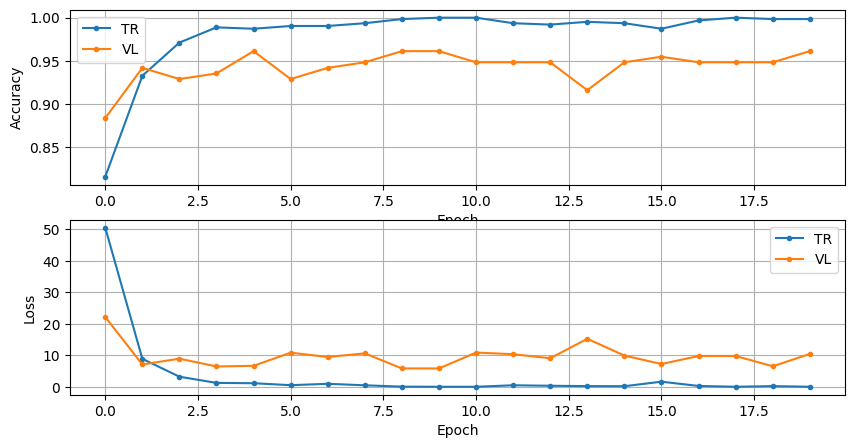

In [ ]:
MCvgg = ModelCheckpoint('/content/drive/MyDrive/2023bigdb/실습/best_model/Mvgg0.tf',
                        monitor='val_loss',
                        save_best_only=True)

Hvgg = Mvgg.fit(TRX, TRy, epochs=20,
                validation_data=(VLX, VLy),
                callbacks=[MCvgg, ES])

plot_history(Hvgg)

In [ ]:
Mvgg0 = keras.models.load_model('/content/drive/MyDrive/2023bigdb/실습/best_model/Mvgg0.tf') # D:/IPRJ/guitar/Mvgg.keras')

test_loss, test_acc = Mvgg0.evaluate(TSX, TSy)

print(f'Test accuracy: {test_acc:.3f}')  # 70%

5/5 [==============================] - 0s 4ms/step - loss: 2.4302 - accuracy: 0.9806
Test accuracy: 0.981


In [ ]:
TSph = Mvgg0.predict(TSX).reshape(-1)

np.round(TSph, 3)

5/5 [==============================] - 0s 3ms/step


array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 1.   , 0.   , 0.   , 0.   , 0.008, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 0.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   ,

In [ ]:
TSyh = np.where(TSph>=0.5, 1, 0)
np.c_[TSy, TSph, TSyh][:5,]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

0.9806451612903225


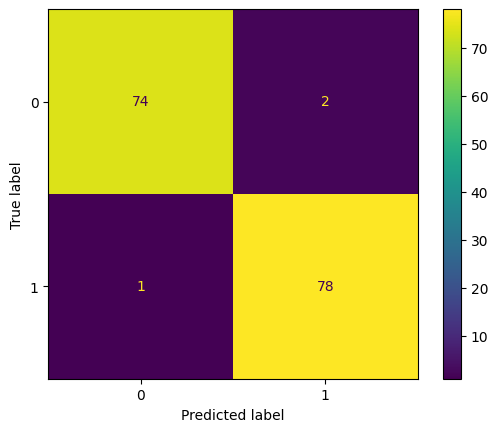

In [ ]:
print(accuracy_score(TSy, TSyh))
disp = ConfusionMatrixDisplay(tf.math.confusion_matrix(labels=TSy, predictions=TSyh).numpy())
disp.plot()

In [ ]:
TSOUT['phvgg'] = TSph
TSOUT['yhvgg'] = TSyh
TSOUT.head()

,y,phcnn,yhcnn,phaug,yhaug,phvgg,yhvgg
0,0,0.421836,0,0.323272,0,0.0,0
1,0,0.738002,1,0.809778,1,0.0,0
2,0,0.492909,0,0.948282,1,0.0,0
3,0,0.103985,0,0.638593,1,0.0,0
4,0,0.708315,1,0.928160,1,0.0,0


In [ ]:
met = pd.DataFrame(
    {'tr_loss':Hvgg.history['loss'][-1],
     'tr_acc':Hvgg.history['accuracy'][-1],
     'val_loss':Hvgg.history['val_loss'][-1],
     'val_acc':Hvgg.history['val_accuracy'][-1],
     'test_loss':test_loss,
     'test_acc':test_acc}, index=['vgg'] )

MET = pd.concat([MET, met])
MET

,tr_loss,tr_acc,val_loss,val_acc,test_loss,test_acc
cnn,0.046731,0.9856,4.036592,0.574194,0.718233,0.483871
aug,0.516871,0.7472,0.783353,0.651613,0.408982,0.806452
vgg,0.004534,0.9984,10.419350,0.961290,2.430204,0.980645


In [ ]:
CNV = VGG16(weights='imagenet',

            include_top=False,   # False면 MLP(Dense)가 없음. 이미지 conv만 처리

            input_shape=(180, 180, 3))

In [ ]:
CNV.trainable = True   # VGG16 훈련함

print('#(trainable weights before freezing CNV base:', len(CNV.trainable_weights))

#(trainable weights before freezing CNV base: 26


In [ ]:
CNV.trainable = False  # VGG16 훈련안함(initiating/freezing VGG16 conv base)

print('#(trainable weights after freezing CNV base:', len(CNV.trainable_weights))

#(trainable weights after freezing CNV base: 0


In [ ]:
AUG = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)])
inp = keras.Input(shape=(180, 180, 3))

x = AUG(inp) # 이미지 증강
x = keras.applications.vgg16.preprocess_input(x)
x = CNV(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outp = layers.Dense(1, activation='sigmoid')(x)
Maugvgg = keras.Model(inp, outp)

Maugvgg.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

Epoch 1/50
20/20 [==============================] - 14s 541ms/step - loss: 61.0268 - accuracy: 0.7360 - val_loss: 6.0611 - val_accuracy: 0.9161
Epoch 2/50
20/20 [==============================] - 4s 173ms/step - loss: 8.3521 - accuracy: 0.8960 - val_loss: 10.0519 - val_accuracy: 0.9290
Epoch 3/50
20/20 [==============================] - 4s 175ms/step - loss: 9.4792 - accuracy: 0.8928 - val_loss: 15.5551 - val_accuracy: 0.8968
Epoch 4/50
20/20 [==============================] - 7s 345ms/step - loss: 4.7558 - accuracy: 0.9440 - val_loss: 5.8702 - val_accuracy: 0.9419
Epoch 5/50
20/20 [==============================] - 3s 138ms/step - loss: 7.8147 - accuracy: 0.9328 - val_loss: 9.4165 - val_accuracy: 0.9290
Epoch 6/50
20/20 [==============================] - 3s 137ms/step - loss: 6.0216 - accuracy: 0.9296 - val_loss: 6.9349 - val_accuracy: 0.9548
Epoch 7/50
20/20 [==============================] - 4s 180ms/step - loss: 3.8689 - accuracy: 0.9488 - val_loss: 6.6056 - val_accuracy: 0.9613
Ep

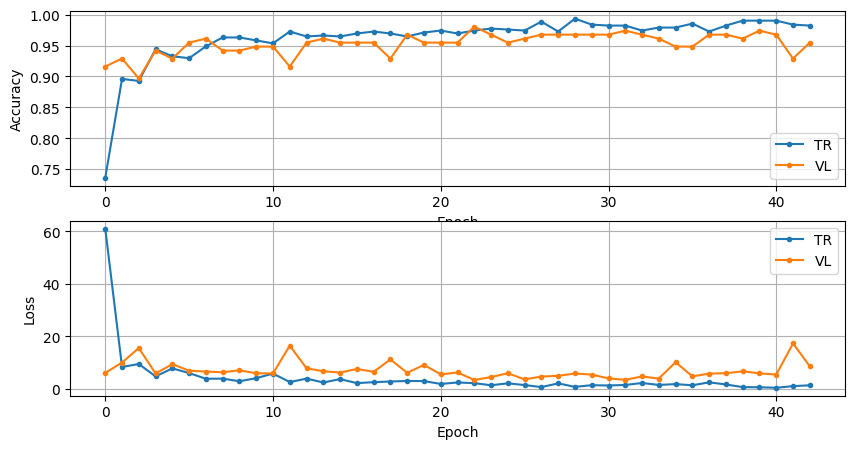

In [ ]:
MCaugvgg = ModelCheckpoint('/content/drive/MyDrive/2023bigdb/실습/best_model/Maugvgg0.tf', #D:/IPRJ/guitar/Maugvgg.tf',
                           monitor='val_loss', save_best_only=True)

Haugvgg = Maugvgg.fit(TRDF, epochs=50,
                      callbacks=[MCaugvgg, ES],
                      validation_data=VLDF)

plot_history(Haugvgg)

In [ ]:
Maugvgg0 = keras.models.load_model('/content/drive/MyDrive/2023bigdb/실습/best_model/Maugvgg0.tf')
test_loss, test_acc = Maugvgg0.evaluate(TSDF)

print(f'Test accuracy: {test_acc:.3f}')  #  69%

155/155 [==============================] - 2s 12ms/step - loss: 3.2687 - accuracy: 0.9677
Test accuracy: 0.968


In [ ]:
TSph = np.array([])

for imgname in imgnames:
    img = keras.utils.load_img(imgname, target_size=(180, 180))
    img_tensor = keras.utils.img_to_array(img)  # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #img_tensor /= 255.

    ph = Maugvgg0.predict(img_tensor, verbose=0).item() # (1,1) 을 (1,)로 변형
    TSph = np.append(TSph, ph)

In [ ]:
TSyh = np.where(TSph>=0.5, 1, 0)
np.c_[TSy, TSph, TSyh][:5,]

array([[0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.]])

0.04516129032258064


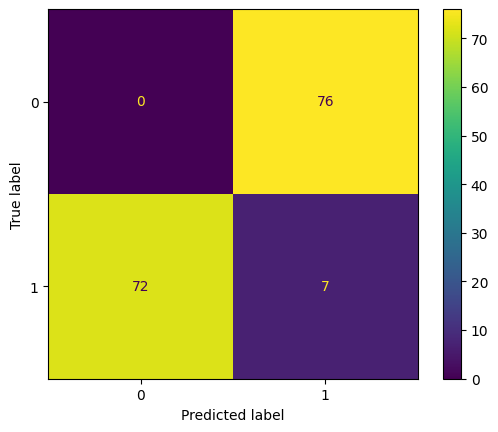

In [ ]:
# tf의 confusion_matrix, sk의 confusion_matrix 충돌
# tf로 구하고, sk로 그리기
# import tensorflow as tf

tf.math.confusion_matrix(labels=TSy, predictions=TSyh) # tensor. numpy()화해야 sk 사용가능

# from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report# confusion_matrix
# print(classification_report(TSy, TSyh)) # Confusing

print(accuracy_score(TSy, TSyh)) # 59.5%  evaluate결과와 다름
disp = ConfusionMatrixDisplay(tf.math.confusion_matrix(labels=TSy, predictions=TSyh).numpy())

disp.plot()

In [ ]:
TSOUT['phaugvgg'] = TSph
TSOUT['yhaugvgg'] = TSyh
TSOUT.head()

,y,phcnn,yhcnn,phaug,yhaug,phvgg,yhvgg,phaugvgg,yhaugvgg
0,0,0.421836,0,0.323272,0,0.0,0,1.0,1
1,0,0.738002,1,0.809778,1,0.0,0,1.0,1
2,0,0.492909,0,0.948282,1,0.0,0,1.0,1
3,0,0.103985,0,0.638593,1,0.0,0,1.0,1
4,0,0.708315,1,0.928160,1,0.0,0,1.0,1


In [ ]:
met = pd.DataFrame(
    {'tr_loss':Haugvgg.history['loss'][-1],
     'tr_acc':Haugvgg.history['accuracy'][-1],
     'val_loss':Haugvgg.history['val_loss'][-1],
     'val_acc':Haugvgg.history['val_accuracy'][-1],
     'test_loss':test_loss,
     'test_acc':test_acc}, index=['augvgg'] )

MET = pd.concat([MET, met])
MET

,tr_loss,tr_acc,val_loss,val_acc,test_loss,test_acc
cnn,0.046731,0.9856,4.036592,0.574194,0.718233,0.483871
aug,0.516871,0.7472,0.783353,0.651613,0.408982,0.806452
vgg,0.004534,0.9984,10.419350,0.961290,2.430204,0.980645
augvgg,1.372495,0.9824,8.605815,0.954839,3.268691,0.967742


In [ ]:
CNV.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
CNV.trainable = True

for layer in CNV.layers[:-4]:
    layer.trainable = False

In [ ]:
Maugvgg.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
               metrics=['accuracy'])

In [ ]:
MCaugvgg_tuned = ModelCheckpoint('/content/drive/MyDrive/2023bigdb/실습/best_model/Maugvgg_tuned0.tf', #D:/IPRJ/guitar/Maugvgg_tuned.tf',
                                 monitor='val_loss',
                                 save_best_only=True)

Epoch 1/30
20/20 [==============================] - 10s 344ms/step - loss: 1.1362 - accuracy: 0.9904 - val_loss: 5.9070 - val_accuracy: 0.9613
Epoch 2/30
20/20 [==============================] - 9s 468ms/step - loss: 0.9420 - accuracy: 0.9872 - val_loss: 5.8775 - val_accuracy: 0.9548
Epoch 3/30
20/20 [==============================] - 7s 302ms/step - loss: 0.4163 - accuracy: 0.9904 - val_loss: 4.3985 - val_accuracy: 0.9548
Epoch 4/30
20/20 [==============================] - 3s 152ms/step - loss: 0.7693 - accuracy: 0.9840 - val_loss: 5.2008 - val_accuracy: 0.9613
Epoch 5/30
20/20 [==============================] - 4s 183ms/step - loss: 0.2823 - accuracy: 0.9904 - val_loss: 5.5028 - val_accuracy: 0.9677
Epoch 6/30
20/20 [==============================] - 3s 151ms/step - loss: 0.2947 - accuracy: 0.9920 - val_loss: 5.4455 - val_accuracy: 0.9613
Epoch 7/30
20/20 [==============================] - 3s 151ms/step - loss: 0.9141 - accuracy: 0.9904 - val_loss: 5.5392 - val_accuracy: 0.9613
Epoch

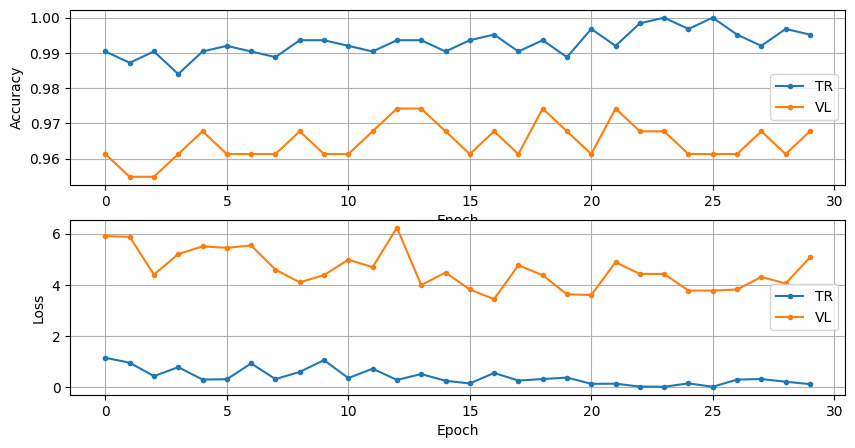

In [ ]:
Haugvgg_tuned = Maugvgg.fit(TRDF, epochs=30,
                          validation_data=VLDF, callbacks=[MCaugvgg_tuned, ES])

plot_history(Haugvgg_tuned)

In [ ]:
Maugvgg_tuned0 = keras.models.load_model('/content/drive/MyDrive/2023bigdb/실습/best_model/Maugvgg_tuned0.tf') #D:/IPRJ/guitar/Maugvgg_tuned.tf')
test_loss, test_acc = Maugvgg_tuned0.evaluate(TSDF)

print(f'Test accuracy: {test_acc:.3f}') # 72%

155/155 [==============================] - 2s 10ms/step - loss: 1.9860 - accuracy: 0.9871
Test accuracy: 0.987


In [ ]:
# https://keras.io/examples/vision/image_classification_from_scratch/ 에 예측하는 방법이 있음

image_size = (180, 180)
img = keras.utils.load_img('/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_071.jpg', target_size=image_size)
img_array = keras.utils.img_to_array(img)

img_array = np.expand_dims(img_array, 0)  # Create batch axis

In [ ]:
ph = Maugvgg_tuned0.predict(img_array) # tf가 (1,1)에 P(y=1|X)를 반환
ph = ph.item()

print(f'This image is {100 * (1 - ph):.2f}% fender and {100 * ph:.2f}% gibson.')

1/1 [==============================] - 0s 185ms/step
This image is 100.00% fender and 0.00% gibson.


In [ ]:
img = keras.utils.load_img('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_023.jpg', target_size=image_size)

img_array = keras.utils.img_to_array(img)

img_array = np.expand_dims(img_array, 0)  # Create batch axis

In [ ]:
ph = Maugvgg_tuned0.predict(img_array) # tf가 (1,1)에 P(y=1|X)를 반환

ph = ph.item()

print(f'This image is {100 * (1 - ph):.2f}% fender and {100 * ph:.2f}% gibson.')

1/1 [==============================] - 0s 146ms/step
This image is 0.00% fender and 100.00% gibson.


In [ ]:
TSph = np.array([])

for imgname in imgnames:
    img = keras.utils.load_img(imgname, target_size=(180, 180))
    img_tensor = keras.utils.img_to_array(img)  # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    #img_tensor /= 255.
    ph = Maugvgg_tuned0.predict(img_tensor, verbose=0).item() # (1,1) 을 (1,)로 변형
    TSph = np.append(TSph, ph)

TSyh = np.where(TSph>=0.5, 1, 0)
np.c_[TSy, TSph, TSyh][:5,]

array([[0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.]])

In [ ]:
tf.math.confusion_matrix(labels=TSy, predictions=TSyh)

0.03225806451612903


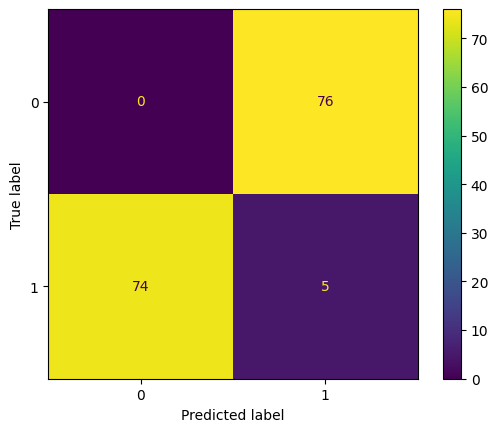

In [ ]:
print(accuracy_score(TSy, TSyh)) # 59.5%  evaluate결과와 다름

disp = ConfusionMatrixDisplay(tf.math.confusion_matrix(labels=TSy, predictions=TSyh).numpy())

disp.plot()

In [ ]:
TSOUT['phaugvgg_tuned'] = TSph
TSOUT['yhaugvgg_tuned'] = TSyh

TSOUT.head()

,y,phcnn,yhcnn,phaug,yhaug,phvgg,yhvgg,phaugvgg,yhaugvgg,phaugvgg_tuned,yhaugvgg_tuned
0,0,0.421836,0,0.323272,0,0.0,0,1.0,1,1.0,1
1,0,0.738002,1,0.809778,1,0.0,0,1.0,1,1.0,1
2,0,0.492909,0,0.948282,1,0.0,0,1.0,1,1.0,1
3,0,0.103985,0,0.638593,1,0.0,0,1.0,1,1.0,1
4,0,0.708315,1,0.928160,1,0.0,0,1.0,1,1.0,1


In [ ]:
met = pd.DataFrame(
    {'tr_loss':Haugvgg_tuned.history['loss'][-1],
     'tr_acc':Haugvgg_tuned.history['accuracy'][-1],
     'val_loss':Haugvgg_tuned.history['val_loss'][-1],
     'val_acc':Haugvgg_tuned.history['val_accuracy'][-1],
     'test_loss':test_loss,
     'test_acc':test_acc}, index=['augvgg_tuned'] )

MET = pd.concat([MET, met])
MET

,tr_loss,tr_acc,val_loss,val_acc,test_loss,test_acc
cnn,0.046731,0.9856,4.036592,0.574194,0.718233,0.483871
aug,0.516871,0.7472,0.783353,0.651613,0.408982,0.806452
vgg,0.004534,0.9984,10.419350,0.961290,2.430204,0.980645
augvgg,1.372495,0.9824,8.605815,0.954839,3.268691,0.967742
augvgg_tuned,0.103616,0.9952,5.069846,0.967742,1.986037,0.987097


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [ ]:
TRIDG = ImageDataGenerator(  # image.IMageDataGenerator 객체
 rescale=1./255,        # 주어진 이미지 크기 설정
 horizontal_flip=True,  # 수평 대칭 50% 확률
 width_shift_range=0.1, # 10%내 좌우이동
 height_shift_range=0.1,# 10%내 상하이동
 #rotation_range=5,     # 정해진 각도만큼 회전
 #shear_range=0.7,#전단변환(한 점 고정 나머지 이동)
 #zoom_range=1.2,       # 확대 또는 축소
 #vertical_flip=True,   # 수직 대칭 50%
 #fill_mode='nearest'   # 빈 공간 색 채우기
)

TRFFD = TRIDG.flow_from_directory('/content/drive/MyDrive/2023bigdb/실습/data/TR', #'D:/IPRJ/guitar/data0/tr',
                                  target_size=(180, 180),
                                  batch_size=5,
                                  class_mode='binary')

Found 625 images belonging to 2 classes.


In [ ]:
VLIDG =ImageDataGenerator(rescale=1./255)

VLFFD = VLIDG.flow_from_directory('/content/drive/MyDrive/2023bigdb/실습/data/VL',
                                  target_size=(180, 180),
                                  batch_size=5,
                                  class_mode='binary')

Found 155 images belonging to 2 classes.


In [ ]:
TSIDG =ImageDataGenerator(rescale=1./255)
TSFFD =TSIDG.flow_from_directory('/content/drive/MyDrive/2023bigdb/실습/data/TS',
                                 target_size=(180, 180),
                                 batch_size=1,  # 이미지 1개씩 처리해야 함
                                 shuffle=False, # False 지정하지 않으면 예측결과가 계속 바뀜
                                 class_mode='binary')

Found 155 images belonging to 2 classes.


In [ ]:
CNV = VGG16(weights='imagenet',
            include_top=False,         # False면 MLP(Dense)가 없음. 이미지 conv만 처리
            input_shape=(180, 180, 3))

CNV.trainable = False   # VGG16 훈련안함
CNV.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
Mfine = models.Sequential()
Mfine.add(CNV)
Mfine.add(Flatten())
Mfine.add(Dense(64))
Mfine.add(Activation('relu'))
Mfine.add(Dropout(0.5))
Mfine.add(Dense(1))
Mfine.add(Activation('sigmoid'))
Mfine.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                819264    
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                

In [ ]:
Mfine.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0002),
              metrics=['accuracy'])

In [ ]:
MCfine = ModelCheckpoint('/content/drive/MyDrive/2023bigdb/실습/best_model/Mfine0.tf', # 'D:/IPRJ/guitar/Mfine.tf',

                         monitor='val_loss', save_best_only=True)

In [ ]:
Hfine = Mfine.fit(TRFFD, epochs=30,
                  validation_data=VLFFD,
                  validation_steps=10,
                  callbacks=[MCfine, ES])

Epoch 1/30
125/125 [==============================] - 21s 134ms/step - loss: 0.5493 - accuracy: 0.7136 - val_loss: 0.3500 - val_accuracy: 0.8200
Epoch 2/30
125/125 [==============================] - 15s 122ms/step - loss: 0.3879 - accuracy: 0.8304 - val_loss: 0.2565 - val_accuracy: 0.8800
Epoch 3/30
125/125 [==============================] - 11s 90ms/step - loss: 0.3221 - accuracy: 0.8656 - val_loss: 0.3284 - val_accuracy: 0.8800
Epoch 4/30
125/125 [==============================] - 10s 76ms/step - loss: 0.2860 - accuracy: 0.8736 - val_loss: 0.1791 - val_accuracy: 0.9400
Epoch 5/30
125/125 [==============================] - 11s 90ms/step - loss: 0.2363 - accuracy: 0.9024 - val_loss: 0.2255 - val_accuracy: 0.9000
Epoch 6/30
125/125 [==============================] - 14s 110ms/step - loss: 0.2017 - accuracy: 0.9232 - val_loss: 0.1042 - val_accuracy: 0.9800
Epoch 7/30
125/125 [==============================] - 20s 162ms/step - loss: 0.1548 - accuracy: 0.9488 - val_loss: 0.2665 - val_accur

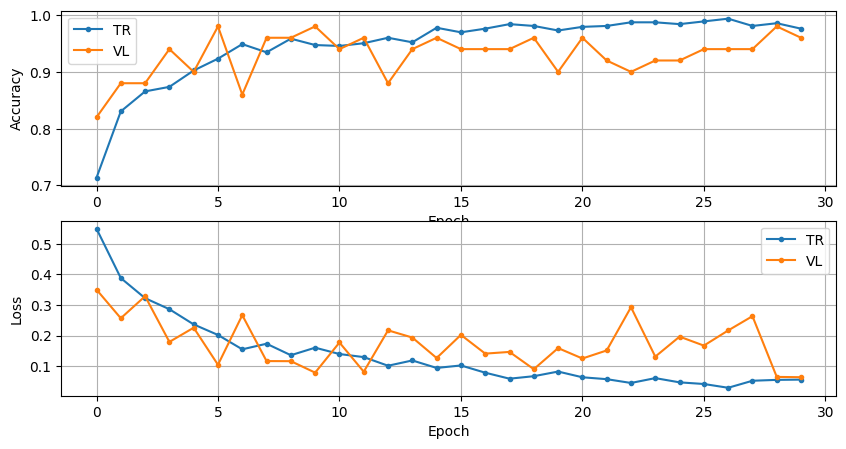

In [ ]:
plot_history(Hfine)

In [ ]:
Mfine0 = keras.models.load_model('/content/drive/MyDrive/2023bigdb/실습/best_model/Mfine0.tf')

test_loss, test_acc = Mfine0.evaluate(TSFFD)

print(f'Test accuracy: {test_acc:.3f}') # 70.5%

155/155 [==============================] - 2s 11ms/step - loss: 0.0702 - accuracy: 0.9677
Test accuracy: 0.968


In [ ]:
img_size=(180,180)
img = keras.utils.load_img('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_075.jpg', target_size=image_size)
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)  # Create batch axis
img_array = img_array/255.

In [ ]:
ph = Mfine0.predict(img_array) # tf가 (1,1)에 P(y=1|X)를 반환

ph = ph.item()

print(f'This image is {100 * (1 - ph):.2f}% fender and {100 * ph:.2f}% gibson.')

1/1 [==============================] - 0s 142ms/step
This image is 1.86% fender and 98.14% gibson.


1/1 [==============================] - 0s 21ms/step
This image is 0.00% fender and 100.00% gibson.


0.9999918937683105

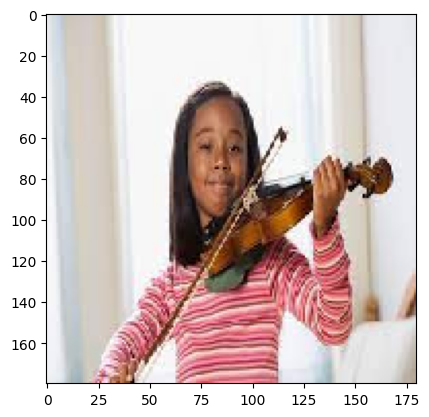

In [ ]:
def evaluate_image(imgfile, plot=True, rescale=True):
    img_size=(180,180)
    img = keras.utils.load_img(imgfile, target_size=image_size)
    if plot:
        plt.imshow(img)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, 0)  # Create batch axis

    if rescale:
        img_array = img_array/255.   # 여기빠지면 ????
    ph = Mfine0.predict(img_array)   # tf가 (1,1)에 P(y=1|X)를 반환
    ph = ph.item()
    print(f'This image is {100 * (1 - ph):.2f}% fender and {100 * ph:.2f}% gibson.')
    return ph

evaluate_image(imgnames[9])

1/1 [==============================] - 0s 21ms/step
This image is 100.00% fender and 0.00% gibson.
1/1 [==============================] - 0s 23ms/step
This image is 100.00% fender and 0.00% gibson.
1/1 [==============================] - 0s 21ms/step
This image is 100.00% fender and 0.00% gibson.
1/1 [==============================] - 0s 18ms/step
This image is 100.00% fender and 0.00% gibson.
1/1 [==============================] - 0s 19ms/step
This image is 21.46% fender and 78.54% gibson.
1/1 [==============================] - 0s 19ms/step
This image is 100.00% fender and 0.00% gibson.
1/1 [==============================] - 0s 18ms/step
This image is 100.00% fender and 0.00% gibson.
1/1 [==============================] - 0s 20ms/step
This image is 100.00% fender and 0.00% gibson.


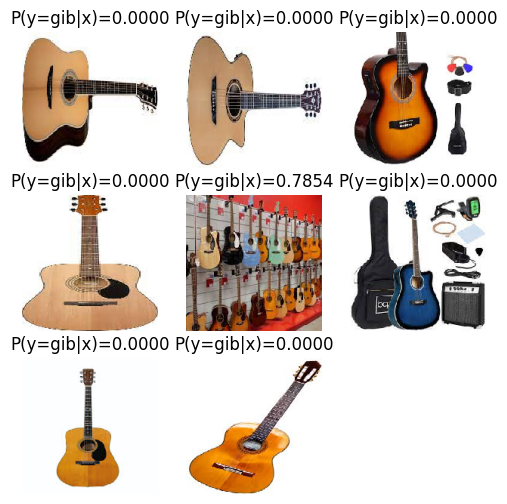

In [ ]:
plt.figure(figsize=(6, 6))
for i, img in enumerate(imgnames[95:103]):
    # print(img)
    ax = plt.subplot(3, 3, i + 1)
    phgibson = evaluate_image(img, rescale=True)
    plt.title(f'P(y=gib|x)={phgibson:.4f}')

    plt.axis('off')

In [ ]:
TSph = [evaluate_image(file, plot=False, rescale=True) for file in imgnames]

TSph = np.array(TSph)

1/1 [==============================] - 0s 29ms/step
This image is 0.00% fender and 100.00% gibson.
1/1 [==============================] - 0s 27ms/step
This image is 0.00% fender and 100.00% gibson.
1/1 [==============================] - 0s 25ms/step
This image is 0.01% fender and 99.99% gibson.
1/1 [==============================] - 0s 33ms/step
This image is 10.86% fender and 89.14% gibson.
1/1 [==============================] - 0s 32ms/step
This image is 0.00% fender and 100.00% gibson.
1/1 [==============================] - 0s 30ms/step
This image is 0.00% fender and 100.00% gibson.
1/1 [==============================] - 0s 30ms/step
This image is 0.78% fender and 99.22% gibson.
1/1 [==============================] - 0s 35ms/step
This image is 0.00% fender and 100.00% gibson.
1/1 [==============================] - 0s 30ms/step
This image is 0.00% fender and 100.00% gibson.
1/1 [==============================] - 0s 43ms/step
This image is 0.00% fender and 100.00% gibson.
1/1 [=======

In [ ]:
TSyh = np.where(TSph>=0.5, 1, 0)

np.c_[TSy, TSph, TSyh][:5,]

array([[0.        , 0.9999963 , 1.        ],
       [0.        , 0.99961782, 1.        ],
       [0.        , 0.99999619, 1.        ],
       [0.        , 0.69242245, 1.        ],
       [0.        , 0.99650097, 1.        ]])

0.05161290322580645


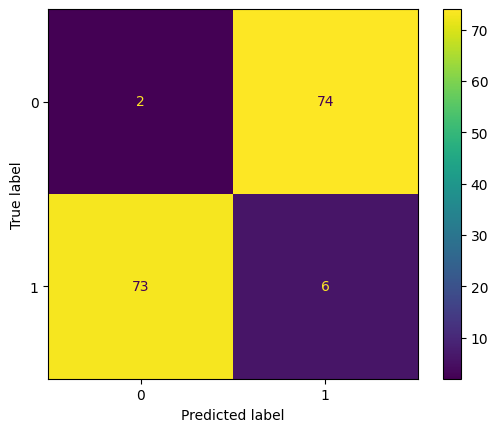

In [ ]:
# import tensorflow as tf
tf.math.confusion_matrix(labels=TSy, predictions=TSyh) # tensor. numpy()화해야 sk 사용가능
# from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report# confusion_matrix
# print(classification_report(TSy, TSyh)) # Confusing

print(accuracy_score(TSy, TSyh)) # 59.5%  evaluate결과와 다름
disp = ConfusionMatrixDisplay(tf.math.confusion_matrix(labels=TSy, predictions=TSyh).numpy())

disp.plot()

In [ ]:
met = pd.DataFrame(
    {'tr_loss':Hfine.history['loss'][-1],
     'tr_acc':Hfine.history['accuracy'][-1],
     'val_loss':Hfine.history['val_loss'][-1],
     'val_acc':Hfine.history['val_accuracy'][-1],
     'test_loss':test_loss,
     'test_acc':test_acc}, index=['fine'] )

MET = pd.concat([MET, met])
MET

,tr_loss,tr_acc,val_loss,val_acc,test_loss,test_acc
cnn,0.046731,0.9856,4.036592,0.574194,0.718233,0.483871
aug,0.516871,0.7472,0.783353,0.651613,0.408982,0.806452
vgg,0.004534,0.9984,10.419350,0.961290,2.430204,0.980645
augvgg,1.372495,0.9824,8.605815,0.954839,3.268691,0.967742
augvgg_tuned,0.103616,0.9952,5.069846,0.967742,1.986037,0.987097
fine,0.055741,0.9760,0.063594,0.960000,0.070204,0.967742


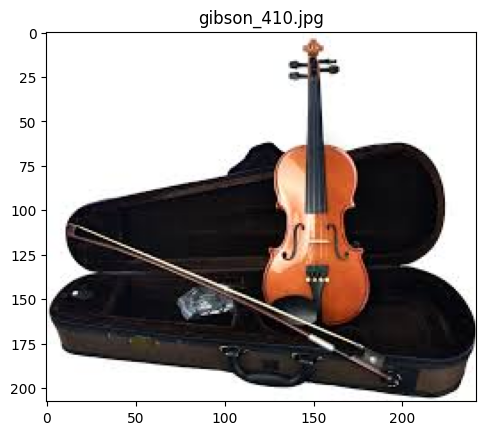

In [ ]:
from matplotlib import image as mpimg
plt.title('gibson_410.jpg')

img = mpimg.imread('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_075.jpg')

plt.imshow(img)

plt.show()

In [ ]:
from PIL import Image
import numpy as np

img = Image.open('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_075.jpg')
img.show()

In [ ]:
def image_to_array(file_path, img_width=180, img_height=180):

    img = Image.open(file_path)

    img = img.resize((img_width,img_height))

    data = np.asarray(img, dtype='float32')

    return data

In [ ]:
x = image_to_array('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_075.jpg')
x.shape  # (180, 180, 3)

(180, 180, 3)

In [ ]:
img = Image.open('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_075.jpg')
x.shape  # (180, 180, 3)')

x = np.array(img)

pilimg = Image.fromarray(x)

pilimg.show()  # 외부 뷰어로 보임



x.shape

(208, 242, 3)

In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

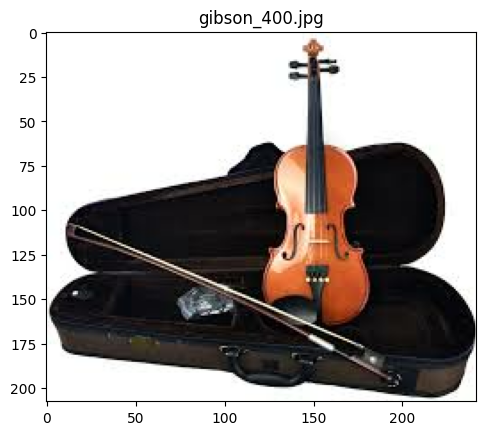

In [ ]:
tf_img = io.read_file('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_075.jpg')

tf_img = image.decode_png(tf_img, channels=3)

# print(tf_img.dtype)

plt.title('gibson_400.jpg')

plt.imshow(tf_img);

In [ ]:
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_001.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_003.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_006.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_023.jpg
/content/drive/MyDrive/2023bigdb/실습/data/TS/guitar/g_022.jpg


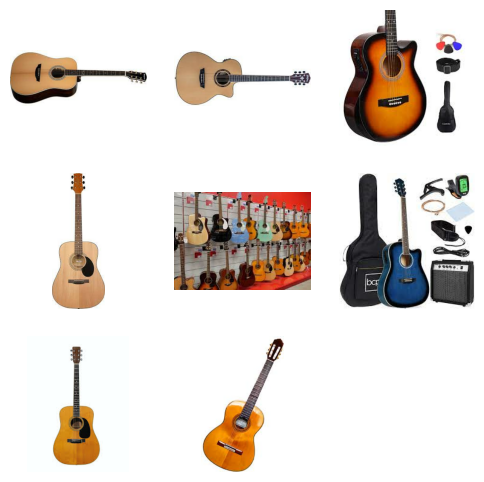

In [ ]:
plt.figure(figsize=(6, 6))

for i, img in enumerate(imgnames[95:103]):
    print(img)
    ax = plt.subplot(3, 3, i + 1)
    im = io.read_file(img)
    im = image.decode_png(im, channels=3)
    plt.imshow(im)
    # plt.title(f'{img}')
    plt.axis('off')

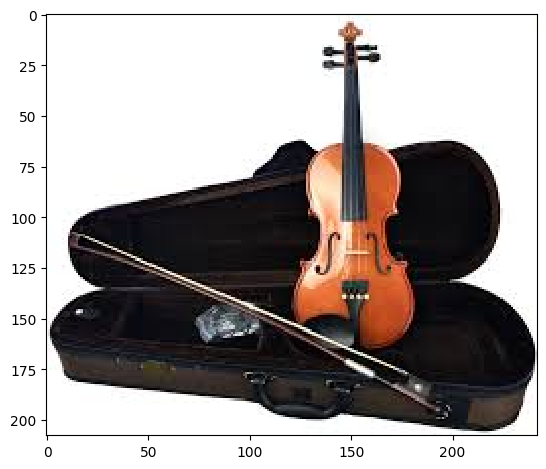

In [ ]:
# ! pip install scikit-image
# from skimage import io

import skimage as skimg
img = skimg.io.imread('/content/drive/MyDrive/2023bigdb/실습/data/TS/violin/v_075.jpg')
skimg.io.imshow(img);

In [ ]:
!pip install scikit-image

In [ ]:
library(keras)
library(tidyverse)


TRfolder <- 'D:/IPRJ/guitar/data0/tr'

VLfolder <- 'D:/IPRJ/guitar/data0/vl'

TSfolder <- 'D:/IPRJ/guitar/data0/ts'

NameError: ignored